# 3 Prepare Geographic Vector Data to Display

## 3.1 Software Requirements

In [1]:
import pandas as pd # Data handling
import geopandas as geopd # Handling shapefile
import matplotlib.pyplot as plt # Generating plots

In addition to these modules, you will likely need to install `descartes` module by `pip install descartes` to use geometric objects with matplotlib.

## 3.2 How to Handle Shapefiles

To handle shapefiles in python, you can use a library called `geopandas`. `read_file()` function of this library reads a shapefile as a `GeoDataFrame` object which is a `pandas.DataFrame` with a geometry column containing vector information.

Operations such as deleting rows and merging with other data frames are the same as for `pandas.DataFrame`. Thus you can manipulate shapefiles just as easily as with normal data frames in pandas.

In [2]:
filename = "./maps/cb_2018_us_state_500k.shp"
sf_us = geopd.read_file(filename)

In [3]:
type(sf_us)

geopandas.geodataframe.GeoDataFrame

We can check what kind of CRS this object is using by `.crs` attribute.

In [4]:
sf_us.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

We can see that this object looks exactly like a `pandas.DataFrame` by printing. 

In [5]:
sf_us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


`geometry` column itself is an object called `GeoSeries`. A `GeoDataFrame` can be thought of as a `DataFrame` that holds a `GeoSeries` inside.

## 3.3 How to Draw a US Map

We can easily draw state boundaries recorded as multi polygons in the `geometry` column using [`.plot()`](https://geopandas.org/reference.html#geopandas.GeoDataFrame.plot)

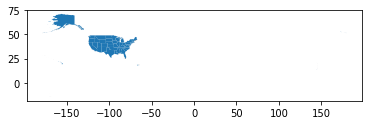

In [6]:
sf_us.plot()
plt.show()

The Census Bureau’s shapefiles also include coordinates for Alaska, Hawaii, or other distant territories, so they are not displayed at the scale we desire. The easiest solution is to drop the rows that contain these off-mainland states and territories.

In [7]:
dropstates = ["Alaska",
              "Hawaii",
              "Puerto Rico",
              "Guam",
              "United States Virgin Islands",
              "Commonwealth of the Northern Mariana Islands",
              "American Samoa"]

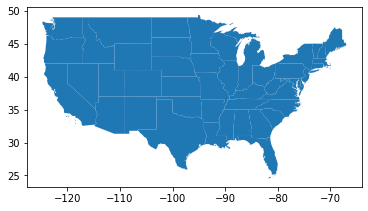

In [8]:
sf_us.query('NAME not in @dropstates').plot()
plt.show()

However, we want to include Alaska and Hawaii because our purpose is to make a state-by-state comparison. Thus, as in the R example, we shrink and shift Alaska and Hawaii to be displayed closer to the mainland.

First, since Alaska is on the date line and divided into two pieces, we need to change the range of longitude from -180-180 to 0-360. Since there is no tool in python similar to the function `st_shift_longitude()` used in the R example (which transfers all coordinates below 0 to between 180-360), we need to create a custom CRS.

The simplest way to achieve this is to edit `proj.4` string. As introduced at the beginning of this tutorial, we can add options to the `proj.4` string. We will add `+lon_wrap=` option to the default NAD83 string in order to change the longitude to be wrapped.

The argument to `+lon_wrap=` is a center longitude. Thus, if we assign `+lon_wrap=180`, the entire coordinates will be shown between 0-360.

To change the CRS, `.to_crs()` method can be used. We only need to pass the desired `proj.4` string as an argument.

In [9]:
# default CRS of our data
nad83 = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
# custom parameter
wrap = "+lon_wrap=180"
# change CRS of our GeoDataFrame
sf_us_360 = sf_us.to_crs(" ".join([nad83,wrap]))

Next we will shift and scale Alaska and Hawaii. There are many [geometric manipulations available in geopandas](https://geopandas.org/geometric_manipulations.html), including affine transformation by a matrix A, and shift, scale, or rotate by a certain latitude and longitude value.

Note that these operations are available for `GeoSeries`, and that the resulting output is only the `geometry` column of the original `GeoDataFrame`. Therefore, after these operations, we need to overwrite the existing `geometry` column with the updated `GeoSeries`. This can be achieved by using `.set_geometry()` method of `GeoDataFrame`.

`.scale()` method returns scaled geometries. It allows us to specify not only the scaling factor in the x-y direction, but also the origin for the scaling operation. We specify `center = 'centroid'` here because we want to scale Alaska and Hawaii around their original place. The amount of shift in the direction of latitude and longitude is the same as the value determined by trial and error in our R example.

In [10]:
Alaska = sf_us_360.query('NAME == "Alaska"')
Alaska_geo = Alaska.scale(xfact=0.3, yfact=0.3, origin='centroid'
                         ).translate(xoff=36, yoff=-38)
Alaska = Alaska.set_geometry(Alaska_geo)

In [11]:
Hawaii = sf_us_360.query('NAME == "Hawaii"')
Hawaii_geo = Hawaii.scale(xfact=0.3, yfact=0.3, origin='centroid'
                                    ).translate(xoff=53, yoff=5)
Hawaii = Hawaii.set_geometry(Hawaii_geo)

In [12]:
sf_us_shifted = geopd.GeoDataFrame(
    pd.concat(
        [sf_us_360.query('NAME not in @dropstates'),
         Alaska,
         Hawaii])
)

`.to_crs()` method can also be used to specify which projection method to use when creating a graphic.
Here we demonstrate the two *Projected CRSs* introduced at the beginning of this tutorial.

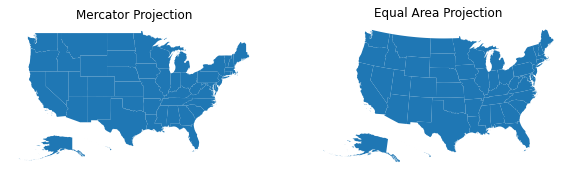

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
sf_us_shifted.to_crs("+proj=merc").plot(ax=ax1)
ax1.set_title("Mercator Projection")
ax1.axis('off')
sf_us_shifted.to_crs("+proj=aea +lat_1=25 +lat_2=50 +lon_0=-100").plot(ax=ax2)
ax2.set_title("Equal Area Projection")
ax2.axis('off')
plt.show()

The final map we will use in the later sections is the one with Alaska and Hawaii, projected by Mercator CRS.

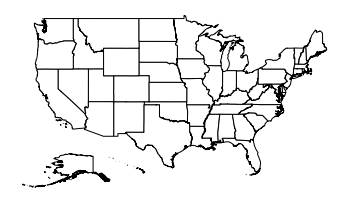

In [14]:
sf_us_shifted.to_crs("+proj=merc").plot(color="white", edgecolor='black')
plt.axis('off')
plt.show()

# 4 Prepare Count Data to Display

## 4.1 Software Requirements

## 4.2 Merge COVID-19 Count with Geographic Data

# 5 Generate Choropleth Maps

## 5.1 Software Requirements

## 5.2 Show Choropleth Maps for each Quarter in 2020